In [38]:
# Extract files in a subfolder
!echo "__TAR__B64__GOES__HERE__" \
    | base64 -d \
    | tar -xvzf -

select/Makefile
select/benchmark.c
select/select.c
select/test.c
select/test.h


In [39]:
%cat select/select.c

#include <stdlib.h>
#include <stddef.h>

int *our_select(int arr[], size_t len, int rank);
int *rand_select(int arr[], size_t len, int rank);

static int *median_of(int arr[], size_t len);
static int *median_of_5(int arr[]);
static size_t partition(int arr[], size_t len, int *pivot);

static void swap(int *a1, int *a2);
static void sort_min_max(int *a1, int *a2);

#define SWAP_IF(v1, v2, cond, a1, a2) {\
  int v1 = *a1, v2 = *a2;\
  *a2 = cond ? v1 : v2;\
  *a1 = cond ? v2 : v1;\
}

int cmp_nums(const void *a1, const void *a2)
{
  // Do not use subtraction as it would overflow
  return (*(int*)a1 > *(int*)a2) ? 1 : (*(int*)a1 < *(int*)a2) ? -1 : 0;
}

int *our_select(int arr[], size_t len, int rank)
{
  if(rank <= 0 || rank > len)
    return NULL;

  // When doing selection on a small array, we can consider it
  // constant time and just use a sorting function to find it
  if(len < 5)
  {
    qsort(arr, len, sizeof(*arr), cmp_nums);
    return &arr[rank - 1];
  }

  // Step 1
  int len

In [40]:
%cat select/test.c

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <ctime>
#include "test.h"

#define ANSI_COLOR_RED     "\x1b"
#define ANSI_COLOR_GREEN   "\x1b"
#define ANSI_COLOR_RESET   "\x1b"

extern int *our_select(int arr[], size_t len, int rank);
extern int *rand_select(int arr[], size_t len, int rank);
extern int cmp_nums(const void *a1, const void *a2);

TEST_INIT_RUNNER((int const *initial, int *a, int len, int rk, char const *test_name) {
  // Run using our function and check for potential failures
  memcpy(a, initial, len * sizeof(*initial));
  int *actual_det_ptr = our_select(a, len, rk);
  bool actual_det_valid = actual_det_ptr != NULL;
  int actual_det = actual_det_valid ? *actual_det_ptr : -1;

  // Run using rand_select and check for potential failures
  memcpy(a, initial, len * sizeof(*initial));
  int *actual_rand_ptr = rand_select(a, len, rk);
  bool actual_rand_valid = actual_rand_ptr != NULL;
  int actual_rand = actual_rand_valid ? *actual_rand_ptr : -1;

  // Ru

In [41]:
%cat select/benchmark.c

#include <benchmark/benchmark.h>
#include <bits/stdc++.h>
#include <ctime>

extern int *our_select(int arr[], size_t len, int rank);
extern int *rand_select(int arr[], size_t len, int rank);
extern int cmp_nums(const void *a1, const void *a2);

class SelectFixture : public benchmark::Fixture
{
private:
  FILE *m_rnd_fd;
  int *m_rnd_arr;
  int m_len;
public:
  void SetUp(::benchmark::State& state)
  {
    // seed the rand() function for use within rand_select()
    srand(time(NULL));

    // open the random fd
    m_rnd_fd = fopen("/dev/urandom", "r");
    if(!m_rnd_fd)
    {
      state.SkipWithError("Failed to open /dev/urandom");
      return;
    }

    // Allocate an array of len given by the benchmark lib
    m_len = state.range(0);
    m_rnd_arr = (int*) malloc(m_len * sizeof(*m_rnd_arr));
    if(!m_rnd_arr)
    {
      state.SkipWithError("Failed to allocate random array");
      return;
    }
  }

  void TearDown(::benchmark::State& state)
  {
    free(m_rnd_arr);
    fclose(m

In [6]:
!git clone https://github.com/google/benchmark.git

Cloning into 'benchmark'...
remote: Enumerating objects: 8850, done.
remote: Counting objects: 100% (1447/1447), done.
remote: Compressing objects: 100% (238/238), done.
remote: Total 8850 (delta 1293), reused 1274 (delta 1195), pack-reused 7403 (from 1)
Receiving objects: 100% (8850/8850), 2.80 MiB | 4.47 MiB/s, done.
Resolving deltas: 100% (5960/5960), done.


In [7]:
!cd benchmark && \
  git checkout 761305ec3b33abf30e08d50eb829e19a802581cc && \
  cmake -E make_directory "build" && \
  cmake -E chdir "build" cmake -DBENCHMARK_DOWNLOAD_DEPENDENCIES=on -DCMAKE_BUILD_TYPE=Release ../ && \
  cmake --build "build" --config Release

Note: switching to '761305ec3b33abf30e08d50eb829e19a802581cc'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 761305e Update user_guide.md (#1863)
-- The CXX compiler identification is GNU 11.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Failed to find LLVM FileCheck
-- Found Git: /usr/bin/git (found version "2.34.1")
-- Google Benchmark vers

In [42]:
!cd select && make test

g++ -O0 -fno-omit-frame-pointer -fsanitize=undefined -fsanitize=address -g select.c test.c -o test.out
./test.out 
PASS '(less than 5)'
    arr: { 3, 84, 12, 50, }
    len: 4, rank: 2
    sorted arr: { 3, 12, 50, 84, }
    expected 12, got deterministic 12 and rand 12
PASS '(less than 5, last element)'
    arr: { 3, 84, 12, 50, }
    len: 4, rank: 4
    sorted arr: { 3, 12, 50, 84, }
    expected 84, got deterministic 84 and rand 84
PASS '(less than 5, first element)'
    arr: { 3, 84, 12, 50, }
    len: 4, rank: 1
    sorted arr: { 3, 12, 50, 84, }
    expected 3, got deterministic 3 and rand 3
PASS '(len % 5 == 1)'
    arr: { 3, 84, 2, 9, 12, 50, }
    len: 6, rank: 4
    sorted arr: { 2, 3, 9, 12, 50, 84, }
    expected 12, got deterministic 12 and rand 12
PASS '(len % 5 == 2)'
    arr: { 3, 7, 84, 12, 15, 17, 23, 11, 98, 81, 60, 50, }
    len: 12, rank: 5
    sorted arr: { 3, 7, 11, 12, 15, 17, 23, 50, 60, 81, 84, 98, }
    expected 15, got deterministic 15 and rand 15
PASS '(len %

g++ -O3 -march=native select.c benchmark.c -std=c++11 -isystem ../benchmark/include -L../benchmark/build/src -lbenchmark -lpthread -o benchmark.out
taskset -c 0 \
	./benchmark.out \
	--benchmark_out=benchmark.json \
	--benchmark_out_format=json
2024-10-21T10:41:01+00:00
Running ./benchmark.out
Run on (2 X 2200 MHz CPU s)
CPU Caches:
  L1 Data 32 KiB (x1)
  L1 Instruction 32 KiB (x1)
  L2 Unified 256 KiB (x1)
  L3 Unified 56320 KiB (x1)
Load Average: 0.44, 0.44, 0.56
------------------------------------------------------------------------------------------
Benchmark                                                Time             CPU   Iterations
------------------------------------------------------------------------------------------
SelectFixture/BM_select/4/manual_time                  131 ns          564 ns      5907369
SelectFixture/BM_select/8/manual_time                  136 ns          527 ns      4843181
SelectFixture/BM_select/16/manual_time                 334 ns          737

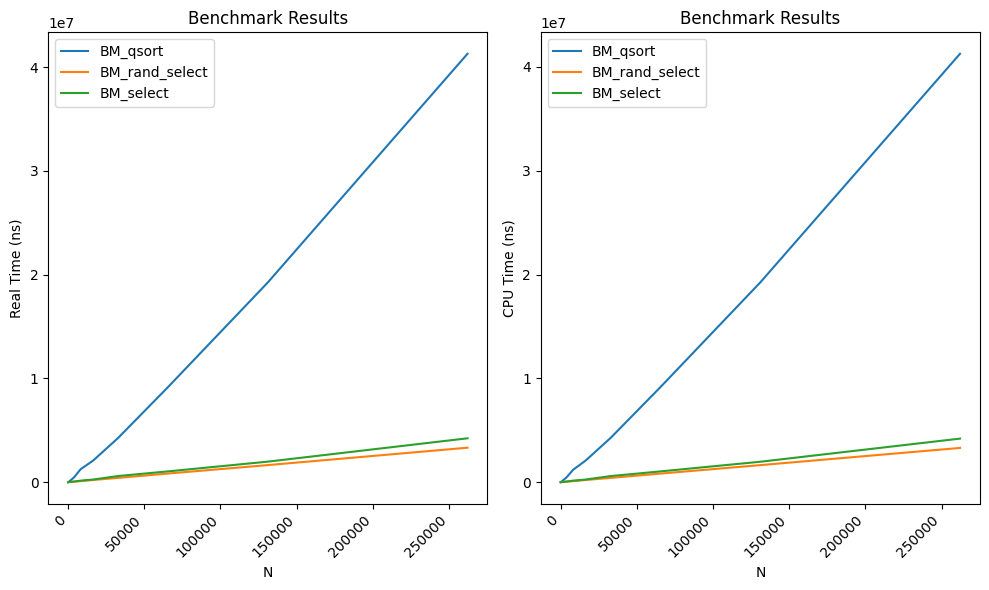

In [37]:
import json
import matplotlib.pyplot as plt

!cd select && make benchmark
print("")

# Load the JSON data
with open('select/benchmark.json', 'r') as f:
    data = json.load(f)

# Filter benchmark where run_type is iteration or mean aggregate
benchmarks = [
    benchmark for benchmark in data['benchmarks'] if
      benchmark['run_type'] == 'iteration' or
       (benchmark['run_type'] == 'aggregate' and benchmark['aggregate_name'] == 'mean')
]
# Sort benchmarks by name and N
benchmarks.sort(key=lambda x: (
    x['run_name'].split('/')[-3],
    int(x['run_name'].split('/')[-2])
))

# Extract the relevant data for plotting
plots = {}
for benchmark in benchmarks:
    name = benchmark['run_name'].split('/')[-3]
    N = int(benchmark['run_name'].split('/')[-2])

    if not name in plots:
      plots[name] = {}
      plots[name]['name'] = name
      plots[name]['x_values'] = [N]
      plots[name]['y_values_real'] = [float(benchmark['real_time'])]
      plots[name]['y_values_cpu'] = [float(benchmark['cpu_time'])]
    elif(N not in plots[name]['x_values']):
        plots[name]['x_values'].append(N)
        plots[name]['y_values_real'].append(float(benchmark['real_time']))
        plots[name]['y_values_cpu'].append(float(benchmark['cpu_time']))

plt.figure(figsize=(10, 6))

# Crea il primo grafico (subplot 1)
plt.subplot(1, 2, 1)  # 1 riga, 2 colonne, primo subplot
for name, plot in plots.items():
    plt.plot(plot['x_values'], plot['y_values_real'], label=name)
plt.xlabel('N')
plt.ylabel('Real Time (ns)')
plt.title('Benchmark Results')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Crea il secondo grafico (subplot 2)
plt.subplot(1, 2, 2)  # 1 riga, 2 colonne, secondo subplot
for name, plot in plots.items():
    plt.plot(plot['x_values'], plot['y_values_cpu'], label=name)
plt.xlabel('N')
plt.ylabel('CPU Time (ns)')
plt.title('Benchmark Results')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()